In [ ]:
!pip install torch-summary --quiet
!pip install wandb --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.6/248.6 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.6 MB/s eta 0:00:00


In [ ]:
import os
import gc
import wandb
import signal
from datetime import datetime
import warnings
from tqdm import tqdm
from uuid import uuid4
import numpy as np
import matplotlib.pyplot as plt
import torch
from google.colab import drive
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms

from PIL import Image
import numpy as np
from sklearn.cluster import KMeans
import pandas as pd
from torch import nn
from torch import nn, optim
from torch.nn import Sequential, Conv2d, MaxPool2d, ReLU, BatchNorm2d, Dropout, CrossEntropyLoss, AdaptiveAvgPool2d, Flatten, Linear
from torchsummary import summary


if torch.cuda.is_available():
  device = "cuda"
else:
  device = "cpu"

print(f"Device: {device}")


os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:1024"


Device: cpu


In [ ]:
## Some constant variables
drive.mount('/content/drive')
CAPSTONE_PATH = "/content/drive/MyDrive/CMU/Fall 23/Capstone Project - Team Cylab/CapStone" # replace it with your path to the drive for capstone shared with you
DATA_ROOT_PATH = os.path.join(CAPSTONE_PATH, 'data')
CHECKPOINT_PATH = os.path.join(CAPSTONE_PATH, 'Checkpoints')
DATA_UNSEEN_PATH = os.path.join(DATA_ROOT_PATH, "UNSEEN_DATA")

DATA_UNSEEN_ALL = os.path.join(DATA_UNSEEN_PATH, "ALL")

ALL_IMAGES_PATH = os.path.join(DATA_ROOT_PATH, 'LOW_QUALITY_WITH_OG')

test_unseen_dir = os.path.join(DATA_UNSEEN_PATH, "TEST")
feature_extractor_dir = os.path.join(DATA_UNSEEN_PATH, "FEATURE_EXTRACTOR")

TRAIN_DIR = os.path.join(DATA_ROOT_PATH, 'SPLIT_DATA_WITH_OG', 'Train_V2')

Mounted at /content/drive


In [ ]:
TRAIN_LABELS = sorted(os.listdir(TRAIN_DIR))
# configurations
CONFIG = {
    "batch_size": 32,
    "num_classes": len(TRAIN_LABELS),
    "epochs": 30,
    "learning_rate": 2e-3,
    "momentum": 0.95,
    "weight_decay": 1e-4,
    "label_smoothing": 0.2,
    "scheduler_factor": 0.4,
    "min_lr": 1e-4,
    "scheduler_patience": 3,
    "scheduler_threshold": 0.05,
    'TEAM_MEMBER': 'Schadrack',
    'archetype': 'Resnet50',
    'optim': 'AdamW'
}

print(f"Configurations:\n")
for key, value in CONFIG.items():
  print(f"{key}: {value}\n")
print()

Configurations:

batch_size: 32

num_classes: 263

epochs: 30

learning_rate: 0.002

momentum: 0.95

weight_decay: 0.0001

label_smoothing: 0.2

scheduler_factor: 0.4

min_lr: 0.0001

scheduler_patience: 3

scheduler_threshold: 0.05

TEAM_MEMBER: Schadrack

archetype: Resnet50

optim: AdamW




In [ ]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, expansion, identity_downsample = None, stride=1):
        super(Block, self).__init__()
        self.expansion = expansion
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels*self.expansion, kernel_size=1, padding=0, stride=1)
        self.bn3 = nn.BatchNorm2d(out_channels*self.expansion)
        self.gelu = nn.GELU()
        self.identity_downsample = identity_downsample

    def forward(self, x):
        identity = x.clone()
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.gelu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.gelu(x)

        x = self.conv3(x)
        x = self.bn3(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.gelu(x)
        return x

In [ ]:
class ResNet(nn.Module):
    def __init__(self, block, layers, image_channels, out_channels, expansion, num_classes):
        super(ResNet, self).__init__()
        self.in_channels = image_channels
        self.conv1 = nn.Conv2d(self.in_channels, self.in_channels, kernel_size = 7, stride = 1, padding = 3) # output shape 224 -> When input shape is 224
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.gelu = nn.GELU()
        self.maxpool = nn.MaxPool2d(kernel_size=5, stride=3) # output shape 73x73


        # REsnet Layers
        self.layer1 = self._make_layer(block, layers[0], out_channels=out_channels, stride=1, expansion=expansion) # output 73
        self.layer2 = self._make_layer(block, layers[1], out_channels=out_channels * expansion//2, stride=2, expansion=expansion) # output 33
        self.layer3 = self._make_layer(block, layers[2], out_channels=out_channels * expansion, stride=2, expansion=expansion) # output 33
        self.layer4 = self._make_layer(block, layers[3], out_channels=out_channels * expansion * 2, stride=2, expansion=expansion) # output 33

        self.avgpool = nn.AdaptiveAvgPool2d((5, 5))

        self.fc = nn.Linear(out_channels * expansion * 2 * expansion * 5 * 5, num_classes)

    def forward(self, x, return_features=False):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.gelu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1) # Reshaping before sending to the fully connected layer

        if return_features:
          return x

        x = self.fc(x)

        return x

    def _make_layer(self, block, num_residual_blocks, out_channels, stride, expansion):
        identity_downsample = None
        layers = []

        if stride != 1 or self.in_channels != out_channels * expansion:
            identity_downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * expansion, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels * expansion)
            )

        layers.append(block(self.in_channels, out_channels, expansion, identity_downsample, stride))
        self.in_channels = out_channels * expansion

        for i in range(1, num_residual_blocks):
            layers.append(block(self.in_channels, out_channels, expansion))

        return nn.Sequential(*layers)

In [ ]:
class Resnet50(ResNet):
    def __init__(self, block, image_channels, out_channels, expansion, num_classes):
        super(Resnet50, self).__init__(block, [3, 4, 6, 3], image_channels, out_channels, expansion, num_classes)
        self.database = {} # keeps class with its corresponding features which will be used for dot product predictions

    def train_model(self, optimizer, dataloader, criterion, scaler, device='cpu'):
        self.train() # put the model into train mode
        total_batches = len(dataloader)
        num_correct = 0
        train_acc = 0
        total_loss = 0
        total_images = 0 # images model has already seen
        batch_bar = tqdm(total=total_batches, dynamic_ncols=True, leave=False, position=0, desc='Train', ncols=5)

        for index, (images, labels) in enumerate(dataloader):
            images, labels = images.to(device), labels.to(device) # moving data to same device with the model
            total_images += len(images)
            optimizer.zero_grad() # zeroing the previous gradients
            with torch.cuda.amp.autocast(): # allowing mixed precission during forward propagation
                logits = self(images) # forward pass
                loss = criterion(logits, labels) # calculating the loss/divergence

            # Find number of correct predictions and add them to previous correct total of predictions
            num_correct += int((torch.argmax(logits, axis=1) == labels).sum()) # make summation and cast it to integer
            train_acc = num_correct * 100 / total_images
            total_loss += float(loss.item()) # find the loss

            # Adding monitoring data to tqdm bar
            batch_bar.set_postfix(
                train_acc="{:.04f}%".format(train_acc),
                train_loss="{:.04f}".format(total_loss / (index + 1)),
                correct_preds="{}".format(num_correct),
                lr="{:.04f}".format(optimizer.param_groups[0]['lr'])
            )

            batch_bar.update()

            # Backward pass
            scaler.scale(loss).backward()

            # Gradient descent to update parameter
            scaler.step(optimizer)
            scaler.update()

            # Release some memory
            del images, labels, logits

            if torch.cuda.is_available():
                torch.cuda.empty_cache()

        batch_bar.close()
        total_loss /= total_batches

        return train_acc, total_loss


    def validate_model(self, dataloader, criterion, device='cpu'):
        self.eval() # put the model into evaluation mode
        total_batches = len(dataloader)
        num_correct = 0
        val_acc = 0
        val_loss = 0
        total_images = 0 # images model has already seen
        batch_bar = tqdm(total=total_batches, dynamic_ncols=True, leave=False, position=0, desc='Validation', ncols=5)

        for index, (images, labels) in enumerate(dataloader):
            images, labels = images.to(device), labels.to(device)
            total_images += len(images)
            with torch.inference_mode(): # inferring
                logits = self(images) # forward pass
                loss = criterion(logits, labels) # Loss calculation

            num_correct += int((torch.argmax(logits, axis=1) == labels).sum())
            val_acc = num_correct * 100 / total_images
            val_loss = loss.item()

            # Adding monitoring data to tqdm bar
            batch_bar.set_postfix(
                train_acc="{:.04f}%".format(val_acc),
                train_loss="{:.04f}".format(val_loss / (index + 1)),
                correct_preds="{}".format(num_correct)
            )

            batch_bar.update()

            del images, labels, logits

            if torch.cuda.is_available():
                torch.cuda.empty_cache()

        batch_bar.close()
        val_loss /= total_batches

        return val_acc, val_loss


    def predict_with_classifier(self, dataloader, device='cpu', labels_names=None):
        self.eval() # put the model into evaluation mode
        batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc='Classifier Predict', ncols=5)
        prediction_results = []
        for index, images in enumerate(dataloader):
            if type(images) in [tuple, list]:
              images = images[0]
            images = images.to(device)
            with torch.inference_mode():
                logits = self(images)

            # detaching the from the computational graph and convert result to list
            logits = torch.argmax(logits, axis=1).detach().cpu().numpy().tolist()
            prediction_results.extend(logits)

            batch_bar.update()
            del logits

            if torch.cuda.is_available():
                torch.cuda.empty_cache()

        batch_bar.close()

        if labels_names: # return predicted class names
            predicted_classes = []
            for prediction in prediction_results:
              predicted_classes.append(labels_names[prediction])

            return prediction_results, predicted_classes

        return prediction_results



    def extract_best_features_by_clustering(self, features):
        # Apply Clustering Algorithm
        n_clusters = 5 # The number of clusters, because we need one D
        cluster_model = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
        cluster_model.fit(features)

        # Obtain Cluster Representations
        cluster_assignments = cluster_model.predict(features)
        cluster_centers = cluster_model.cluster_centers_

        # Generate Final Feature Vector
        # final_feature_vector = np.concatenate(cluster_centers, axis=0)  # Concatenate cluster centers

        return torch.tensor(cluster_centers.mean(axis=0))


    def extract_features(self, dataloader, label_names, extractor_func='mean', device='cpu'):
        """
        This method extracts the features and keeps them in the self.database
        These features will be used for making predictions with dot product
        params:
          extractor_func: this is a function to be use for either everaging or choosing the mean
        """
        self.eval()  # put the model into evaluation mode

        for label_name in label_names: # Removing the existing classes in database
            self.drop_class(label_name, False)

        batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc='Features Extractor', ncols=5)
        for images, labels in dataloader:
            images = images.to(device) # return features
            with torch.inference_mode():
                features_batch = self(images, return_features=True)

            # detaching the from the computational graph and convert result to list
            features_batch = features_batch.detach().cpu().numpy().tolist()
            for features, actual_label in zip(features_batch, labels.cpu().numpy().tolist()):
                    if label_names[actual_label] in label_names:
                        self.database[label_names[actual_label]] = self.database.get(label_names[actual_label], []) + [features]


            batch_bar.update()

            del features
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

        batch_bar.close()
        # Taking the average of features accross each image
        message = extractor_func.lower().capitalize() + " Features" if extractor_func.lower()!= "mean" else "Averaging Features"
        batch_bar = tqdm(total=len(self.database), dynamic_ncols=True, leave=False, position=0, desc=message, ncols=5)
        for key, value in self.database.items():
            if key in label_names:
                if extractor_func.lower() == 'median':
                    self.database[key] = torch.median(torch.tensor(value).to(device=device), axis=0).values
                elif extractor_func.lower() == 'clustering':
                    self.database[key] = self.extract_best_features_by_clustering(torch.tensor(value).to(device=device).detach().cpu().numpy()).to(device)
                else:
                    self.database[key] = torch.mean(torch.tensor(value).to(device=device), axis=0)

            batch_bar.update()

            del key, value

            if torch.cuda.is_available():
                torch.cuda.empty_cache()

        batch_bar.close()


    def predict_with_dot_product(self, dataloader, device='cpu'):
        self.eval() # put the model into evaluation mode
        batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc='Dot Product Predict', ncols=5)
        prediction_results = []
        values = list(model.database.values())
        database_features = torch.cat(values, dim=0).view(-1, len(values[0]))
        database_labels = list(self.database.keys())

        del values

        for index, images in enumerate(dataloader):
            if type(images) in [tuple, list]:
              images = images[0]
            images = images.to(device)
            with torch.inference_mode():
                features = self(images, return_features=True)

            # detaching the from the computational graph and convert result to list
            database_features = database_features.to(dtype=images.dtype)
            logits = database_features @ features.T
            logits = torch.argmax(logits, axis=0).detach().cpu().numpy().tolist()
            prediction_results.extend(logits)

            batch_bar.update()
            del logits

            if torch.cuda.is_available():
                torch.cuda.empty_cache()

        batch_bar.close()

        predicted_classes = []
        for prediction in prediction_results:
            predicted_classes.append(database_labels[prediction])

        del prediction_results

        return predicted_classes


    def get_database_len(self):
      return len(list(self.database.keys()))


    def get_database_classes(self):
      return list(self.database.keys())


    def get_database(self):
      return self.database


    def drop_class(self, class_name, print_msg=True):
      if self.database.get(class_name, None) is not None:
          del self.database[class_name]
      else:
        if print_msg:
            print(f"\nClass {class_name}\n")

In [ ]:
# function which loads only the model
def load_model_checkpoint(path, model, device='cpu'):
    checkpoint = torch.load(path, map_location=device)

    model.load_state_dict(checkpoint["model_state"])
    database = checkpoint["database"]

    model.database = database

    return model


# Function for setting the states checkpoints
def save_model_checkpoint(path, model, device='cpu'):
    """
        Function saves  model state
        args:
            model: the model to be saved
    """
    checkpoint = torch.load(path, map_location=device)
    checkpoint["model_state"] = model.state_dict()
    checkpoint["database"] = model.database

    torch.save(checkpoint, path)

In [ ]:
def normalize_image_and_convert_to_pil(image):
  denormalize_image = transforms.Normalize(mean=[1/0.485, 1/0.456, 1/0.406], std=[1/0.229, 1/0.224, 1/0.225])(image)
  return np.array(transforms.ToPILImage()(denormalize_image))

In [ ]:
def plot_pil_images(images, labels_names, labels_numbers, figsize: tuple=None):
    if len(images) == 0:
        raise ValueError("Images cannot be empty")

    rows = int(np.sqrt(len(images)))
    cols = len(images) - rows

    if cols > rows:  #  I want rows to be greater than cols
        temp = rows
        rows = cols
        cols = temp

    fig, axes = plt.subplots(nrows=rows, ncols=cols)
    if figsize and len(images)!=1:
        fig.set_size_inches(figsize[0], figsize[1])

    if len(images) == 1:
            axes.imshow(normalize_image_and_convert_to_pil(images[0]))
            axes.axis('off')
            axes.set_title(labels_names[0])

    elif len(images) < 3:
        for i in range(len(images)):
            axes[i].imshow(normalize_image_and_convert_to_pil(images[i]))
            axes[i].axis('off')
            axes[i].set_title(labels_names[i])
    else:
        count_image = 0
        for row in range(rows):
            for col in range(cols):

                if count_image == len(images):
                    break

                axes[row, col].imshow(normalize_image_and_convert_to_pil(images[count_image]))
                axes[row, col].axis('off')
                axes[row, col].set_title(labels_names[count_image])
                count_image += 1

            if count_image == len(images):
                    break


    plt.show()

In [ ]:
# Prepare images for predictions
def create_image_batch(image_path):
    """
      This function create batch of one image
    """
    transformation = transforms.Compose([
                      transforms.Resize(size=(224, 224)),
                      transforms.ToTensor(),
                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                  ]
                  )
    image_names = os.listdir(image_path)
    images = []
    for image_name in image_names:
        image = transformation(Image.open(os.path.join(image_path, image_name)))
        images.append(image.unsqueeze(dim=0))

    images = torch.cat(images, dim=0)

    return images


def load_image(image_path):
    transformation = transforms.Compose([
                      transforms.Resize(size=(224, 224)),
                      transforms.ToTensor(),
                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                  ]
                  )
    image = transformation(Image.open(os.path.join(image_path)))

    return image


In [ ]:
# Adding new class to the model
def add_class_to_model(model, images_batch, label_names, extractor_func, device='cpu'):
    model.extract_features(images_batch, label_names, extractor_func, device)

In [ ]:
# Making predictions with dot product
def make_dot_product_prediction(model, images_batch, device='cpu'):
    preds = model.predict_with_dot_product(images_batch, device)
    return preds

In [ ]:
def check_prediction_statistics(predicted, actual_labels):
    misclassified = []
    correct_classified = []
    correct = 0
    counts = 0
    for predict, actual_label in zip(predicted, actual_labels):
        counts += 1
        if predict == actual_label:
            correct += 1
            correct_classified.append(predict)
        else:
            misclassified.append(predict)
    return misclassified, correct_classified, correct * 100 / counts


def plot_classifications(mis_classfied_data, correct_classified_data, all_preds, figsize=(10, 10)):
    label_names = []
    images = []
    for class_name in mis_classfied_data:
        path = os.path.join(ALL_IMAGES_PATH, class_name)
        if not os.path.exists(path):
            path = os.path.join(DATA_UNSEEN_ALL, class_name)

        all_images = os.listdir(path)

        indx = all_preds.index(class_name)
        path = os.path.join(path, all_images[indx])
        images.append(load_image(path))

        label_names.append('misclassified_' + class_name )


    for class_name in correct_classified_data:
        path = os.path.join(ALL_IMAGES_PATH, class_name)
        if not os.path.exists(path):
            path = os.path.join(DATA_UNSEEN_ALL, class_name)

        all_images = os.listdir(path)

        indx = all_preds.index(class_name)
        path = os.path.join(path, all_images[indx])
        images.append(load_image(path))

        label_names.append('correct_classified_' + class_name )


    plot_pil_images(images, label_names, list(range(len(label_names))), figsize)



# Testing Model

In [ ]:
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    torch.cuda.memory_summary(device=device, abbreviated=False)

# Tesing the model creation
model = Resnet50(Block, 3, 62, 4, CONFIG["num_classes"]).to(device)

# summary(model, [3, 224, 224])

#Loading the model checkpoint

In [ ]:
checkpoint_name_mean = "{}_best_checkpoint_{}_V2_mean.pth".format(CONFIG['TEAM_MEMBER'], CONFIG['archetype'])
checkpoint_path = os.path.join(CHECKPOINT_PATH, checkpoint_name_mean)

FEATURE_EXTRACTOR_CLASSES = os.listdir(feature_extractor_dir)
TEST_CLASSES = os.listdir(test_unseen_dir)


## Loading model
model = load_model_checkpoint(checkpoint_path, model)

#Adding New Classes To The Model - Mean Feature Analysis

In [ ]:
## Testing adding new class
##Already new added classes
new_added_classes = [(os.path.join(feature_extractor_dir, FEATURE_EXTRACTOR_CLASSES[0]), FEATURE_EXTRACTOR_CLASSES[0]),
                     (os.path.join(feature_extractor_dir, FEATURE_EXTRACTOR_CLASSES[1]), FEATURE_EXTRACTOR_CLASSES[1])]


# Path to the new class to be added into the model, this path contains images for that particular image
# The class name should be the final folder in the path and contains it s images only


############## Adding new class
add_new_image_path = os.path.join(feature_extractor_dir, FEATURE_EXTRACTOR_CLASSES[0])
# Reading and converting images to batch of tensors
images = create_image_batch(add_new_image_path)
add_images_batches = [(images, torch.tensor([0] * images.shape[0]))]  # Zero indicates the index of label which is always one because we are adding one class at time
add_class_to_model(model, add_images_batches, [FEATURE_EXTRACTOR_CLASSES[0]], 'mean', device) # Added class is FEATURE_EXTRACTOR_CLASSES[0]


############## Adding new class
add_new_image_path = os.path.join(feature_extractor_dir, FEATURE_EXTRACTOR_CLASSES[1])
# Reading and converting images to batch of tensors
images = create_image_batch(add_new_image_path)
add_images_batches = [(images, torch.tensor([0] * images.shape[0]))]  # Zero indicates the index of label which is always one because we are adding one class at time
add_class_to_model(model, add_images_batches, [FEATURE_EXTRACTOR_CLASSES[1]], 'mean', device) # Added class is FEATURE_EXTRACTOR_CLASSES[0]


############## Adding new class
add_new_image_path = os.path.join(feature_extractor_dir, FEATURE_EXTRACTOR_CLASSES[2])
# Reading and converting images to batch of tensors
images = create_image_batch(add_new_image_path)
add_images_batches = [(images, torch.tensor([0] * images.shape[0]))]  # Zero indicates the index of label which is always one because we are adding one class at time
add_class_to_model(model, add_images_batches, [FEATURE_EXTRACTOR_CLASSES[2]], 'mean', device) # Added class is FEATURE_EXTRACTOR_CLASSES[0]

############## Adding new class
add_new_image_path = os.path.join(feature_extractor_dir, FEATURE_EXTRACTOR_CLASSES[3])
# Reading and converting images to batch of tensors
images = create_image_batch(add_new_image_path)
add_images_batches = [(images, torch.tensor([0] * images.shape[0]))]  # Zero indicates the index of label which is always one because we are adding one class at time
add_class_to_model(model, add_images_batches, [FEATURE_EXTRACTOR_CLASSES[3]], 'mean', device) # Added class is FEATURE_EXTRACTOR_CLASSES[0]


############## Adding new class
add_new_image_path = os.path.join(feature_extractor_dir, FEATURE_EXTRACTOR_CLASSES[4])
# Reading and converting images to batch of tensors
images = create_image_batch(add_new_image_path)
add_images_batches = [(images, torch.tensor([0] * images.shape[0]))]  # Zero indicates the index of label which is always one because we are adding one class at time
add_class_to_model(model, add_images_batches, [FEATURE_EXTRACTOR_CLASSES[4]], 'mean', device) # Added class is FEATURE_EXTRACTOR_CLASSES[0]



# Save model database
save_model_checkpoint(checkpoint_path, model, device)


#Predictions Using Dot Product - Mean Feature Analysis

In [ ]:
# Path to the class to predict images arrange should similar to the above one
# new_image_to_predict_path = os.path.join(test_unseen_dir, TEST_CLASSES[0])

total_correct = 0
total_images = 0
preds = []
print("\nCATTLE CLASS\tACCURACY(%)\n===========================\n")
for i in range(len(TEST_CLASSES)):
  new_image_to_predict_path = os.path.join(test_unseen_dir, TEST_CLASSES[i])

  # Predicting on new image
  images = create_image_batch(new_image_to_predict_path)
  # images = images[0:3].unsqueeze(dim=0).unsqueeze(dim=0)  # crearting 4D input for to have (num_batches, batch_size, channels, image_H, image_W), this is single image
  images = images.unsqueeze(dim=0) # more than one image
  pred = make_dot_product_prediction(model, images, device)  # prediction for a single image -> Target class is TEST_CLASSES[0]
  preds.append(pred)
  mis_classified, correct_classified, accuracy = check_prediction_statistics(pred, [TEST_CLASSES[i]] * len(pred))

  total_correct += len(correct_classified)
  total_images += len(correct_classified) + len(mis_classified)

  print(f"{TEST_CLASSES[i]} \t{round(accuracy, 3)}%")
  print("===========================\n")

print(f"\nOverall accuracy: {round(total_correct * 100 / total_images, 3)}%\n")



CATTLE CLASS	ACCURACY(%)



cattle_1500 	100.0%



cattle_1200 	100.0%



cattle_1600 	85.714%



cattle_0600 	100.0%



cattle_0500 	100.0%


Overall accuracy: 97.143%



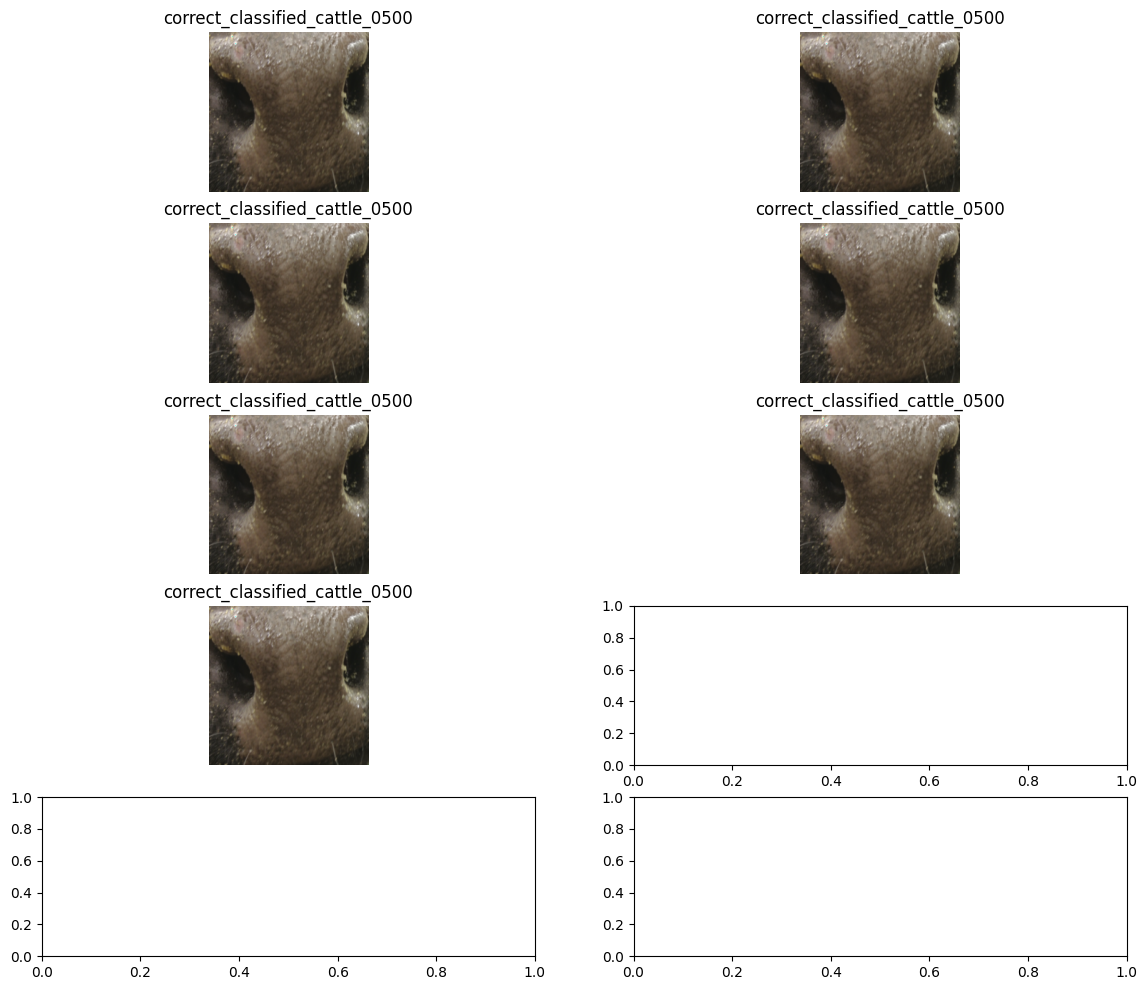

In [ ]:
mis_classified, correct_classified, accuracy = check_prediction_statistics(preds[i], [TEST_CLASSES[i]] * len(preds[i]))

plot_classifications(mis_classified, correct_classified, preds[i], (14, 12))

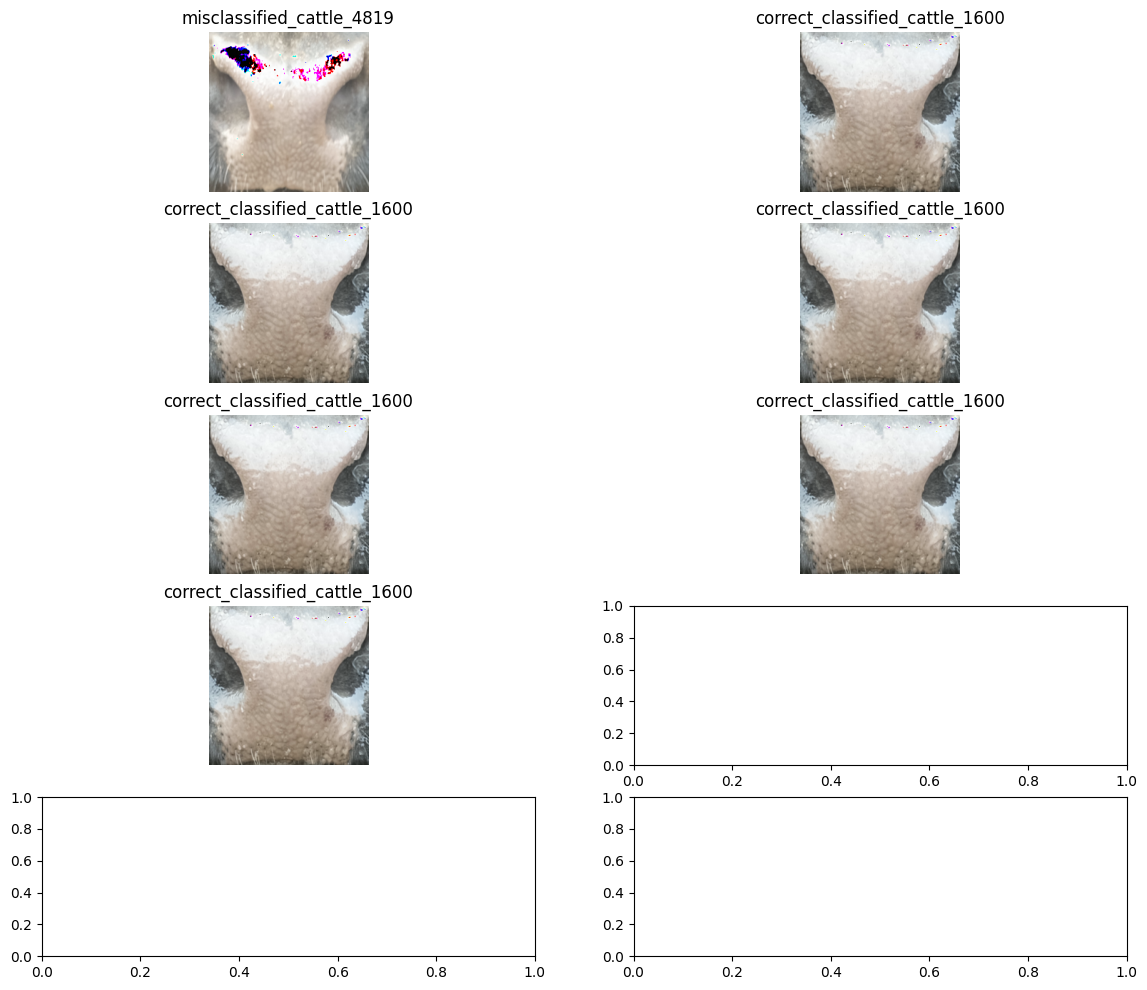

In [ ]:
mis_classified, correct_classified, accuracy = check_prediction_statistics(preds[2], [TEST_CLASSES[2]] * len(preds[2]))

plot_classifications(mis_classified, correct_classified, preds[2], (14, 12))